100%|██████████| 50/50 [00:00<00:00, 1942.71it/s]


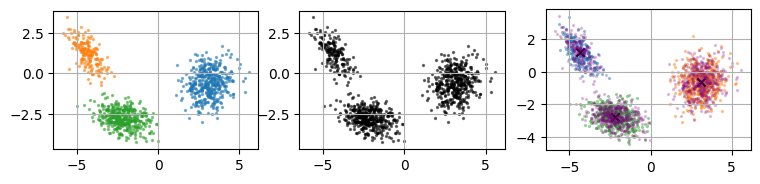

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from GMMEM import GMM
from torch.distributions.multivariate_normal import MultivariateNormal
torch.manual_seed(0)

Nmix=3
Nd=2

means_gt = torch.randn(Nmix,Nd)*2

# Covariance Mats 
# update for Nd not equal to 2
Eigs_gt = torch.stack([ torch.tensor([[np.cos(theta),np.sin(theta)],
                          [-np.sin(theta),np.cos(theta)]]).to(torch.float) 
                 
                 for theta in 2*np.pi*torch.rand(Nmix)])

Ds_gt = torch.stack([torch.tensor([[torch.rand(1),0],
                                    [0,torch.rand(1)]]).to(torch.float) 
                 
                     for n in range(Nmix)])

covs_gt = torch.einsum("MDC,MCB,MBA->MDA",Eigs_gt,Ds_gt,Eigs_gt.transpose(-2,-1))

mixc_gt = torch.rand(Nmix)
mixc_gt = mixc_gt/(mixc_gt.sum())
mns=[MultivariateNormal(loc=means_gt[i,:],covariance_matrix=covs_gt[i,...]) for i in range(Nmix)]
samples=[]
Nsamples=1000

plt.figure(figsize=(9,3))
plt.subplot(1,3,1)
for mn_idx,mn in enumerate(mns):
    Nsamples_per_gaussian=int(mixc_gt[mn_idx]*Nsamples)
    new_samples=mn.sample((Nsamples_per_gaussian,))
    plt.scatter(new_samples[:,0],new_samples[:,1],alpha=0.5,s=2,marker="o")
    samples.append(new_samples)
samples=torch.concat(samples,dim=0)

plt.gca().set_aspect(1)
plt.grid()

plt.subplot(1,3,2)
plt.scatter(samples[:,0],samples[:,1],color="k",s=2,alpha=0.5)
plt.gca().set_aspect(1)
plt.grid()

Nmix_use=3
Ndim_use=2
gmm=GMM(means=torch.randn(Nmix,Ndim_use)*1,
        covs=torch.concat([torch.eye(Ndim_use)[None,...] for i in range(Nmix_use)],dim=0),
        mixc=torch.ones(Nmix_use)/Nmix_use)

gmm.forward(x=samples,Niter=50)

plt.subplot(1,3,3)
from torch.distributions.multivariate_normal import MultivariateNormal
mns_fit=[MultivariateNormal(loc=gmm.means[i,:],covariance_matrix=gmm.covs[i,...]) for i in range(Nmix)]
for mn_idx,mn in enumerate(mns_fit):
    Nsamples_per_gaussian=int(gmm.mixc[mn_idx]*Nsamples)
    new_samples=mn.sample((Nsamples_per_gaussian,))
    plt.scatter(new_samples[:,0],new_samples[:,1],alpha=0.5,s=2,marker="x")
    plt.scatter(gmm.means[mn_idx,0],gmm.means[mn_idx,1],marker="x",color="k")
plt.scatter(samples[:,0],samples[:,1],color="purple",s=2,alpha=0.2)

plt.gca().set_aspect(1)
plt.grid()
